In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings('ignore')

import math

from sklearn import tree
from sklearn.model_selection import train_test_split

get_ipython().magic(u'matplotlib inline') #para imprimir no próprio notebook

# Visualisation

In [2]:
#Funções auxiliares
def plot_correlation_map( df, figsize = (12,10)):
    corr = df.corr().round(2)
    _ , ax = plt.subplots(figsize = figsize)
    cmap = sns.diverging_palette(220,10, as_cmap=True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax, 
        annot=True, 
        annot_kws={'fontsize':12}
    )
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df,row = row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [3]:
#Adaptado de https://www.kaggle.com/sachinkulkarni/titanic/an-interactive-data-science-tutorial
#carrega a base de dados
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
full = train.append(test , ignore_index = True)
print("Datasets:\nCompleto: " , full.shape, "\nTreinamento:", train.shape,"\nTeste:",test.shape)

Datasets:
Completo:  (1309, 12) 
Treinamento: (891, 12) 
Teste: (418, 11)


In [4]:
#Identifica as características presentes
train.columns.values

#Descrição das variáveis
#We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:
#Variable Description
#Survived: Survived (1) or died (0)
#Pclass: Passenger's class
#Name: Passenger's name
#Sex: Passenger's sex
#Age: Passenger's age
#SibSp: Number of siblings/spouses aboard
#Parch: Number of parents/children aboard
#Ticket: Ticket number
#Fare: Fare
#Cabin: Cabin
#Embarked: Port of embarkation

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [5]:
#Análise dos dados. Observe que é possível identificar dados inconsistentes. Por exemplo, idade mínima de 0.42!
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


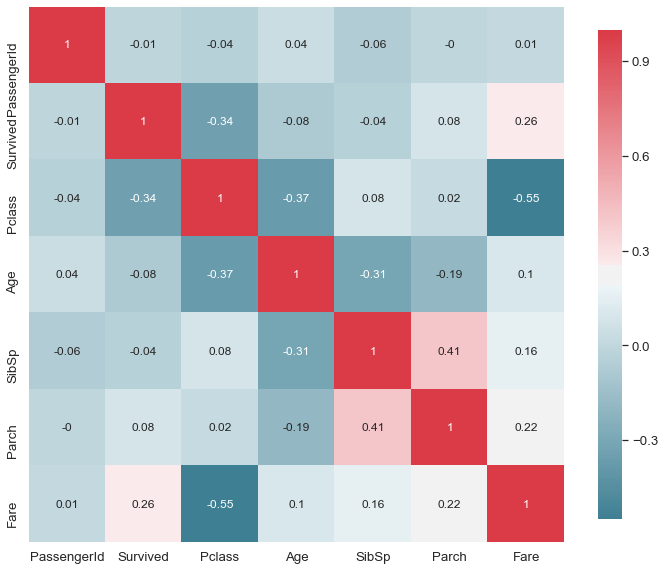

In [6]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(train)

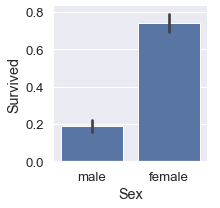

In [7]:
#Distribuição das amostras dentro de uma mesma classe
#Visualize a "Survival Rate" em relação aos seguintes atributos: Embarked, Sex, Pclass, SibSp, Parch
plot_categories(train, cat = 'Sex', target = 'Survived')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b7a7bfcc0>,
      dtype=object)

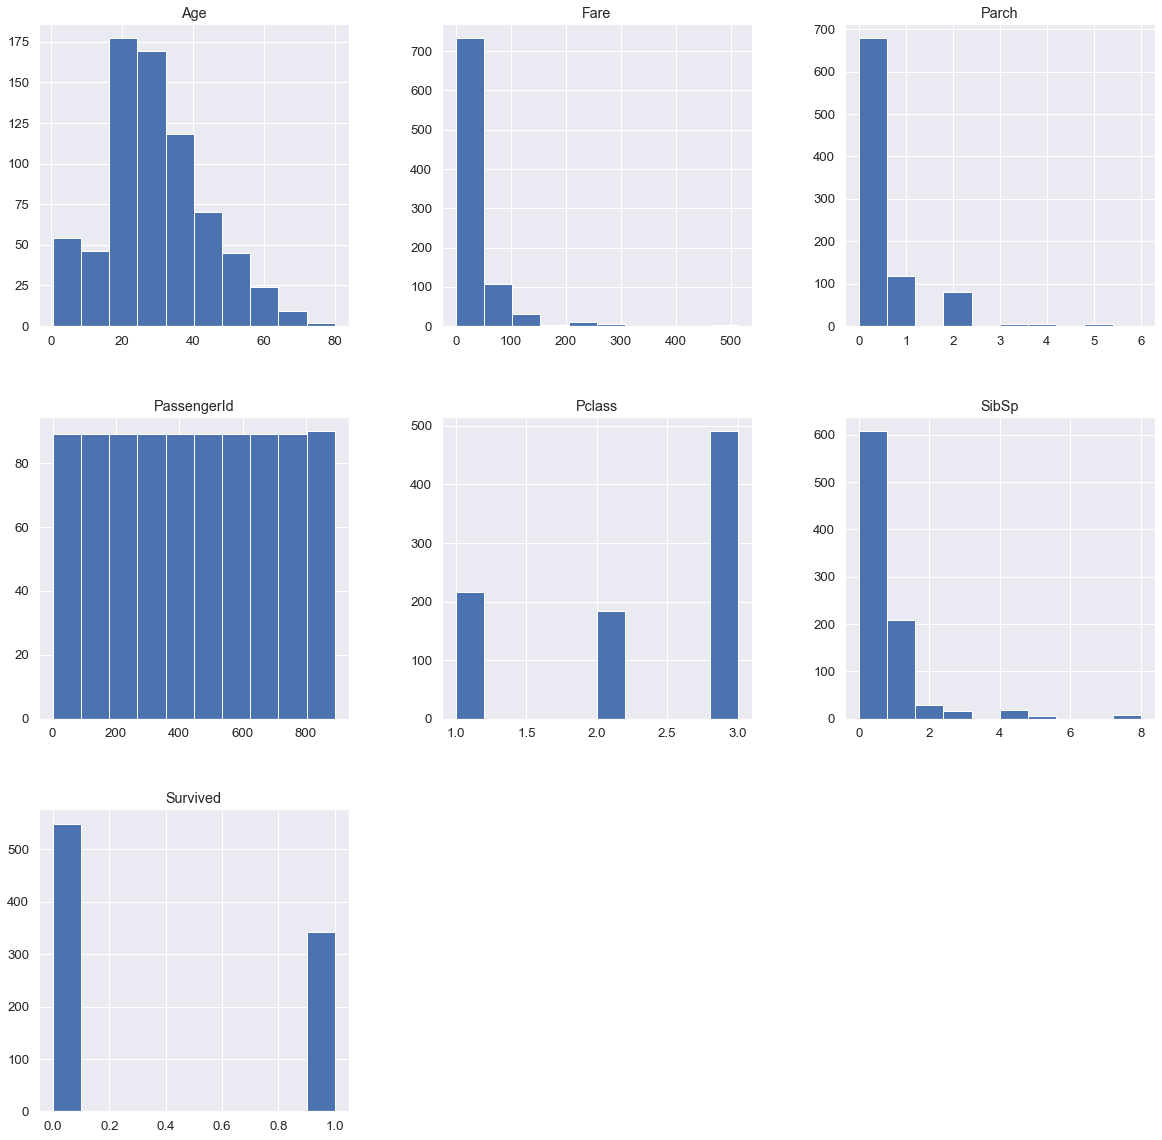

In [8]:
train.hist(figsize=(20,20))

# Ajustando os dados

### Novas colunas

In [9]:
#Altera o atributo "Sex" de valores nominais (Male/Female)para 0 e 1
full["Male"] = (full.Sex == "male").astype(int)
full = full.drop(['Sex'],axis=1)
full.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,SibSp,Survived,Ticket,Male
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,0.0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1.0,PC 17599,0


In [10]:
#Cria uma nova variável para cada valor único de "Embarked" (no caso, Embarked_C  Embarked_Q  Embarked_S)
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')
#Cria uma nova variável para cada valor único de "Pclass"
pclass = pd.get_dummies(full.Pclass , prefix='Pclass' )

print(embarked.sum())
print(pclass.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,embarked,pclass],axis=1)
full = full.drop(['Embarked','Pclass'],axis=1)
full.head(2)

Embarked_C    270
Embarked_Q    123
Embarked_S    914
dtype: int64
Pclass_1    323
Pclass_2    277
Pclass_3    709
dtype: int64


,Age,Cabin,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,1,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,0,1,0,0,1,0,0


In [11]:
#As distinções refletiam o status social e podem ser utilziados para prever a probabilidade de sobrevivência

title = pd.DataFrame()

#Extrai o título de cada nome
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

#Lista agregada de títulos
Title_Dictionary = {
                    "Capt":       "Officer",#Officer
                    "Col":        "Officer",#Officer
                    "Major":      "Officer",#Officer
                    "Jonkheer":   "Royalty",#Royalty
                    "Don":        "Royalty",#Royalty
                    "Sir" :       "Royalty",#Royalty
                    "Dr":         "Officer",#Officer
                    "Rev":        "Officer",#Officer
                    "the Countess":"Royalty",#Royalty
                    "Dona":       "Royalty",#Royalty
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"#Royalty
                    }

#Faz o mapeamento de cada título
title['Title'] = title.Title.map(Title_Dictionary)
#Cria uma nova variável para cada título
title = pd.get_dummies(title.Title)

print(title.sum())

#junta novas colunas 
full = pd.concat([full,title],axis=1)
full = full.drop(['Name'],axis=1)
full.head(2)

Master      61
Miss       262
Mr         757
Mrs        200
Officer     23
Royalty      6
dtype: int64


,Age,Cabin,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,...,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty
0,22.0,NaN,7.2500,0,1,1,0.0,A/5 21171,1,0,...,1,0,0,1,0,0,1,0,0,0
1,38.0,C85,71.2833,0,2,1,1.0,PC 17599,0,1,...,0,1,0,0,0,0,0,1,0,0


In [12]:
#Extrai a categoria da cabine a partir do número
cabin = pd.DataFrame()

#Substitui dados faltantes por "U" (Uknown)
cabin['Cabin'] = full.Cabin.fillna( 'U' )

#Mapeia cada valor de cabine com a letra
cabin['Cabin'] = cabin['Cabin'].map(lambda c : c[0])

#Cria uma variável para cada categoria
cabin = pd.get_dummies(cabin['Cabin'] , prefix = 'Cabin')

print(cabin.sum())
#junta pois tem poucos dados 
cabin['Cabin_AB'] = cabin['Cabin_A']+cabin['Cabin_B']
cabin['Cabin_DE'] = cabin['Cabin_D']+cabin['Cabin_E']
cabin['Cabin_FG'] = cabin['Cabin_F']+cabin['Cabin_G']
cabin = cabin.drop(["Cabin_A","Cabin_B","Cabin_D","Cabin_E","Cabin_F","Cabin_G","Cabin_T"],axis=1)

print(cabin.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,cabin],axis=1)
full = full.drop(['Cabin'],axis=1)

full.head(2)

Cabin_A      22
Cabin_B      65
Cabin_C      94
Cabin_D      46
Cabin_E      41
Cabin_F      21
Cabin_G       5
Cabin_T       1
Cabin_U    1014
dtype: int64
Cabin_C       94
Cabin_U     1014
Cabin_AB      87
Cabin_DE      87
Cabin_FG      26
dtype: int64


,Age,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
0,22.0,7.2500,0,1,1,0.0,A/5 21171,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,38.0,71.2833,0,2,1,1.0,PC 17599,0,1,0,...,0,0,1,0,0,1,0,0,0,0


A nomenclatura das cabines está relacionada com a sua posição no navio, assim, unimos as cabines mais próximas. 
<img src="cabines.png" width=350>

In [13]:
'''
#Removido por possuir poucas amostras por cada classe
#Extrai a classe de cada ticket a partir do seu número
#Caso não tenha prefixo, retorna XXX
def cleanTicket( ticket ):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

#Cria uma nova variável para cada caso
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )
print(ticket.sum())
'''
#junta novas colunas e remove antigas
#full = pd.concat([full,ticket],axis=1)

full = full.drop(['Ticket'],axis=1)
#full.head(2)
#ticket.shape

Decidimos não adicionar os tickets pois adiciona muitas colunas com pouco valor.

In [14]:
'''
#Cria variáveis para representar o tamanho da família e também cada categoria
family = pd.DataFrame()

#Cria nova característica que representa o tamanho da família (quantidade de membros)
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1

#Cria nova características para representar o tipo de família 
family['Family_Single'] = family['FamilySize'].map(lambda s : 1 if s == 1 else 0)
#family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 4 else 0)
#family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 5 <= s else 0)
family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 3 else 0)
family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 4 <= s else 0)
print(family.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,family],axis=1)
full = full.drop(['FamilySize'],axis=1)

full.head(2)
'''
None

Decidimos não adicionar _FamilySize_ pois essa informação já esta em _Parch_ e _SibSp_.

In [15]:
full = full.drop(["PassengerId"],axis=1)
full.shape

(1309, 23)

### Missing Values

In [16]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 23 columns):
Age           1046 non-null float64
Fare          1308 non-null float64
Parch         1309 non-null int64
SibSp         1309 non-null int64
Survived      891 non-null float64
Male          1309 non-null int64
Embarked_C    1309 non-null uint8
Embarked_Q    1309 non-null uint8
Embarked_S    1309 non-null uint8
Pclass_1      1309 non-null uint8
Pclass_2      1309 non-null uint8
Pclass_3      1309 non-null uint8
Master        1309 non-null uint8
Miss          1309 non-null uint8
Mr            1309 non-null uint8
Mrs           1309 non-null uint8
Officer       1309 non-null uint8
Royalty       1309 non-null uint8
Cabin_C       1309 non-null uint8
Cabin_U       1309 non-null uint8
Cabin_AB      1309 non-null uint8
Cabin_DE      1309 non-null uint8
Cabin_FG      1309 non-null uint8
dtypes: float64(3), int64(3), uint8(17)
memory usage: 83.2 KB


In [17]:
#Muitos algoritmos requerem que todas as amostras possuam valores atribuídos para todas as características. 
#No caso de dados faltantes, uma possibilidade é preenchê-los com o valor médio das demais observações.

#Preenche os valores que faltam em "Age" com a média das demais idades
full['Age'] = full.Age.fillna(full.Age.mean())

#O mesmo para "Fare"
full['Fare'] = full.Fare.fillna(full.Fare.mean())

full.head(2)

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
0,22.0,7.2500,0,1,0.0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,38.0,71.2833,0,1,1.0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [18]:
#Seleciona as características que serão incluídas no descritor (vetor de características)
#full_all = pd.concat([imputed, embarked, family, sex, title, full.Survived] , axis=1)
#full_all.head()

# Visualisation 2

In [19]:
#separa novamente dados de traino e test
survived = full['Survived'][:train.shape[0]]
train = full[:train.shape[0]]
test = full[train.shape[0]:]
test = test.drop(['Survived'],axis=1)

train.shape,test.shape

((891, 23), (418, 22))

In [20]:
#Análise dos dados. Observe que é possível identificar dados inconsistentes. Por exemplo, idade mínima de 0.42!
train.describe()

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.735277,32.204208,0.381594,0.523008,0.383838,0.647587,0.188552,0.086420,0.722783,0.242424,...,0.206510,0.580247,0.142536,0.020202,0.005612,0.066218,0.771044,0.069585,0.072952,0.019080
std,13.002218,49.693429,0.806057,1.102743,0.486592,0.477990,0.391372,0.281141,0.447876,0.428790,...,0.405028,0.493796,0.349796,0.140770,0.074743,0.248802,0.420397,0.254589,0.260203,0.136882
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,29.881138,14.454200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,35.000000,31.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,80.000000,512.329200,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


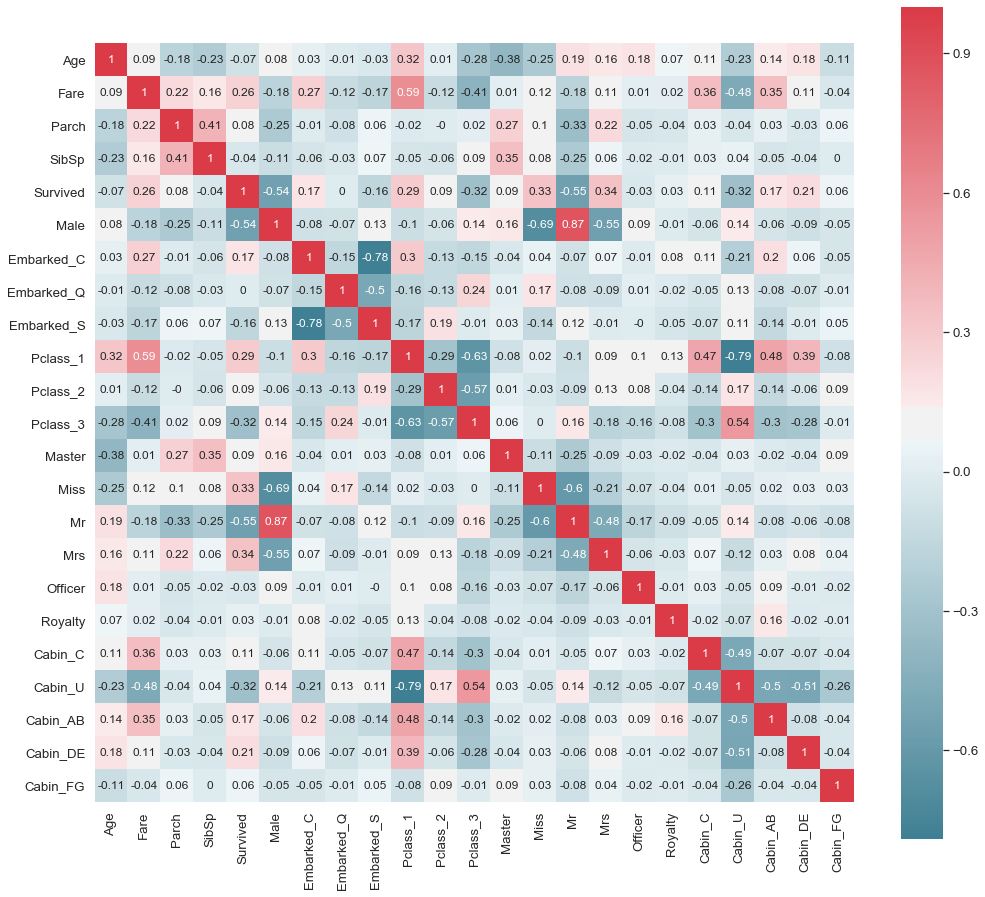

In [21]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(train,figsize=(17,17))

In [22]:
%%time
#g = sns.pairplot(train,vars=train.columns[:-1], hue='Survived')#, palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
#g.savefig("output.png")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


***
# Processo de Classificação

In [33]:
from sklearn.metrics import classification_report
sns.set(font_scale=1.2)

#função utilizada para avaliar todos os modelos
def avalia_resultado(y, y_pred):
    
    # Confusion Matrix
    confusionMatrix = sklearn.metrics.confusion_matrix(y_test, preditor)
    
    df_cm = pd.DataFrame(confusionMatrix, index=["Died","Survived"],columns=["Died","Survived"])
    plt.figure(figsize = (5,3))
    sns.heatmap(df_cm, annot=True)
    
    #avalia métricas
    report = classification_report(y, y_pred, target_names=["Died","Survived"],output_dict = True)
    df_report = pd.DataFrame(report)
    
    return df_report

In [35]:

#A partir apenas das amostras do arquivo train.csv, cria a base de treinamento e teste.
X = full[0:train.shape[0]]
y = survived
X = X.drop(['Survived'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X , y, train_size = .8)

#clf = tree.DecisionTreeClassifier(criterion='gini')
#clf = clf.fit(X_train, y_train)
#preditor = clf.predict(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 22), (179, 22), (712,), (179,))

In [36]:
full.columns

Index(['Age', 'Fare', 'Parch', 'SibSp', 'Survived', 'Male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty', 'Cabin_C',
       'Cabin_U', 'Cabin_AB', 'Cabin_DE', 'Cabin_FG'],
      dtype='object')

### KNN

{'acc': 0.7430167597765364, 'k_value': 39, 'precision': 0.7349692605877761, 'recall': 0.7430167597765364}
{'acc': 0.7374301675977654, 'k_value': 16, 'precision': 0.744130381542528, 'recall': 0.7374301675977654}
{'acc': 0.7374301675977654, 'k_value': 22, 'precision': 0.7339540657976413, 'recall': 0.7374301675977654}


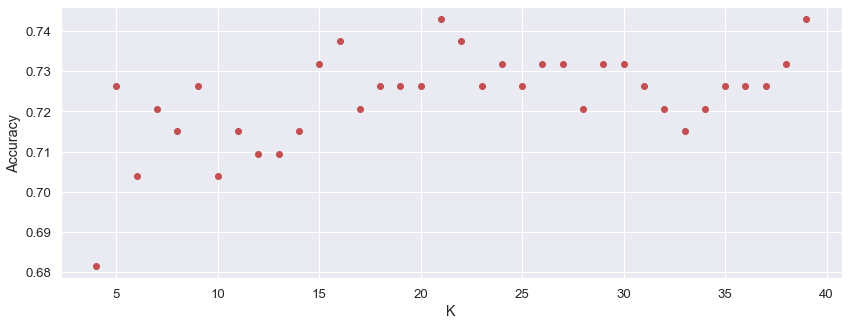

In [37]:
# mostra o desempenho com uma aproximacao de k vizinhos

import sklearn.metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn import neighbors

# para utilizar na ordenacao da lista
def myFunc(e):
    return e['acc']

results=[]
for n_neighbors in range(4,40):
    clf_nkk = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf_nkk.fit(X_train, y_train)
    preditor = clf_nkk.predict(X_test)

    # calcula os parametros de avaliacao
    acc = sklearn.metrics.accuracy_score(y_test, preditor)
    prec = precision_score(y_test, preditor, average='weighted')
    recall = recall_score(y_test, preditor, average='weighted')

    #if conf_matrix == 1:
    #    print(confusion_matrix(y_test, preditor))

    # coloca o resultado na lista
    new_result = {'acc':acc, 'k_value':n_neighbors, 'precision':prec, 'recall':recall}
    results.append(new_result)

# ordena em ordem decrescente de acuracia
results.sort(key=myFunc, reverse=True)

#printa os 3 melhores resultados
print(results[1])
print(results[2])
print(results[3])

# plota o grafico mostrando o desempenho da acuracia de cada k
plt.figure(figsize=(14,5))
plt.xlabel('K')
plt.ylabel('Accuracy')
for result in results:
    plt.plot(result['k_value'], result['acc'], 'ro')
plt.show() 

### Decision Tree

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.851064,0.715447,0.804469,0.783255,0.807879
precision,0.884956,0.666667,0.804469,0.775811,0.815445
recall,0.819672,0.771930,0.804469,0.795801,0.804469
support,122.000000,57.000000,0.804469,179.000000,179.000000


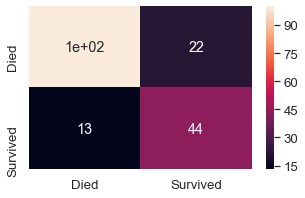

In [38]:
# mostra o desempenho com uma aproximacao de arvores de decisao
# geralmente com profundidade 5 mostra um bom resultado

my_clf = tree.DecisionTreeClassifier(max_depth = 5, min_samples_split = 3, class_weight = 'balanced')
my_clf = my_clf.fit(X, y)

#treina o classificador com a base de treinamento
my_clf.fit(X_train, y_train)

#testa o classificador com a base de testes
preditor = my_clf.predict(X_test)
        
avalia_resultado(y_test, preditor)

In [39]:
#printa arvore
#plt.figure(figsize=(14,8))
#a = tree.plot_tree(my_clf)

### Random Forest

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.857143,0.690265,0.804469,0.773704,0.804003
precision,0.853659,0.696429,0.804469,0.775044,0.803591
recall,0.860656,0.684211,0.804469,0.772433,0.804469
support,122.000000,57.000000,0.804469,179.000000,179.000000


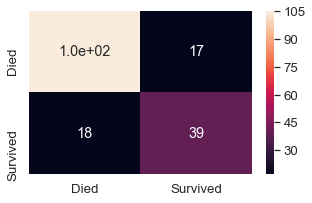

In [40]:
# mostra o desempenho com uma aproximacao de random forests
# geralmente com profundidade 5 mostra um bom resultado

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(X, y)

#treina o classificador com a base de treinamento
clf.fit(X_train, y_train)

#testa o classificador com a base de testes
preditor = clf.predict(X_test)
        
avalia_resultado(y_test, preditor)

### Gaussian Naive Bayes

In [41]:
# mostra o desempenho com uma aproximacao naive bayes

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

#testa o classificador com a base de testes
preditor = gnb.predict(X_test)

#mostrar a acurácia
acc = sklearn.metrics.accuracy_score(y_test, preditor)
print("\nAccuracy\n", acc)


Accuracy
 0.7430167597765364


# Coisas que daria para fazer
 - arrumar ou remover as idades inválidas
 - documentar mais o notebook explicando nossas escolhas e raciocínio
 - testar todas as abordagens com todas as colunas, com menos colunas e utilizando PCA
  - com menos colunas podemos remover Officer, Royalty, Cabin_FG (por terem pouco amostras), Mr (por ter alta correlação com Male) e/ou qualquer outra que não tenha muita importância.
 - testar se melhora o resultado não separar colunas que tem algum significado contínuo ex: Cabin e Pclass (só teria que lembrar de transformar em variável numérica) 
 - utilizar grid search e/ou random search
 - utilizar diferentes métricas e visualizações dos resultados.